In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [2]:
def modelFit(alg, dtrain, predictors, target, performCV = True, printFeatReport = True, cv_folds = 5):
    
    '''alg is the model to fit, dtrain is the training dataframe, predictors is a string or list of
    strings of the column names to use as predictors, target a string of the column with the target
    performCV will crossvalidate the model, printFeatImport will print a graph showing the important
    features, and cv_folds is the number of folds to use in cross validation.'''
    
    alg.fit(dtrain[predictors], dtrain[target])
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], \
                                                   cv = cv_folds, scoring = 'roc_auc' )
    
    print('\nModel Report')
    print('Accuracy : {:.4g}'.format(metrics.accuracy_score(dtrain[target].values, dtrain_predictions)))
    print('AUC Score (Train): {:f}'.format(metrics.roc_auc_score(dtrain[target], dtrain_predprob)))
    
    if performCV:
        print('CV Score: Mean - {:.7g} | Std - {:.7g} | Min - {:.7g} | Max - {:.7g}'.format(np.mean(cv_score),\
                                                                                            np.std(cv_score),\
                                                                                            np.min(cv_score),\
                                                                                            np.max(cv_score)))
    
    if printFeatReport:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
#Import the data!
train = pd.read_csv('Data/Santander/train.csv')
test = pd.read_csv('Data/Santander/test.csv')

dropCols = []
for i in train.columns.values:
    if len(train[i].unique()) == 1:
        dropCols.append(i)
print('Dropping {} columns due to non-unique entries'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

dropCols = []
c = train.columns
for i in range(len(c)-1):
    v = train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train[c[j]].values):
            dropCols.append(c[j])
print('Dropping {} columns due to duplicate columns'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

train.loc[train.var3 < -10000, 'var3'] = np.nan
test.loc[test.var3 < -10000, 'var3'] = np.nan

colsWithNAN = []
for i in train.columns.values:
    if train[i].isnull().sum() > 0:
        colsWithNAN.append(i)
train.drop(colsWithNAN, axis = 1,  inplace = True)
test.drop(colsWithNAN, axis = 1, inplace = True)

Dropping 34 columns due to non-unique entries
Dropping 29 columns due to duplicate columns


In [4]:
pred = [i for i in train.columns if i not in ['ID', 'TARGET']]
gbm0 = GradientBoostingClassifier(random_state = 10)
modelFit(gbm0, train, pred, 'TARGET', printFeatReport = False)


Model Report
Accuracy : 0.9612
AUC Score (Train): 0.854954
CV Score: Mean - 0.8352549 | Std - 0.008035582 | Min - 0.8233546 | Max - 0.8485047


In [5]:
paramTest1 = {'n_estimators' : range(80,141,10)}
gSearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,\
                                                               min_samples_split = 500,\
                                                               min_samples_leaf = 50,\
                                                               max_depth = 8,\
                                                               max_features = 'sqrt',\
                                                               subsample = 0.8,\
                                                               random_state = 10), 
                       param_grid = paramTest1, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch1.fit(train[pred], train['TARGET'])
gSearch1.grid_scores_, gSearch1.best_params_, gSearch1.best_score_

([mean: 0.83770, std: 0.00833, params: {'n_estimators': 80},
  mean: 0.83784, std: 0.00819, params: {'n_estimators': 90},
  mean: 0.83793, std: 0.00867, params: {'n_estimators': 100},
  mean: 0.83757, std: 0.00844, params: {'n_estimators': 110},
  mean: 0.83734, std: 0.00855, params: {'n_estimators': 120},
  mean: 0.83726, std: 0.00826, params: {'n_estimators': 130},
  mean: 0.83698, std: 0.00809, params: {'n_estimators': 140}],
 {'n_estimators': 100},
 0.83792968856907224)

In [6]:
paramTest2 = {'max_depth' : range(5,16,2), 'min_samples_split' : range(200,1001, 200)}
gSearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,\
                                                               n_estimators = 100,\
                                                               min_samples_leaf = 50,\
                                                               max_features = 'sqrt',\
                                                               subsample = 0.8,\
                                                               random_state = 10), 
                       param_grid = paramTest2, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch2.fit(train[pred], train['TARGET'])
gSearch2.grid_scores_, gSearch2.best_params_, gSearch2.best_score_

([mean: 0.83576, std: 0.00915, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.83705, std: 0.00813, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.83613, std: 0.00887, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.83639, std: 0.00912, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.83573, std: 0.00873, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.83491, std: 0.00716, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.83665, std: 0.00764, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.83653, std: 0.00902, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.83680, std: 0.00873, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.83667, std: 0.00902, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.83550, std: 0.00747, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.83760, std: 0.00702, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [8]:
paramTest3 = {'min_samples_leaf' : range(30,71, 10)}
gSearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,\
                                                               n_estimators = 100,\
                                                               max_depth = 9,\
                                                               min_samples_split = 400,\
                                                               max_features = 'sqrt',\
                                                               subsample = 0.8,\
                                                               random_state = 10), 
                       param_grid = paramTest3, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch3.fit(train[pred], train['TARGET'])
gSearch3.grid_scores_, gSearch3.best_params_, gSearch3.best_score_

([mean: 0.83655, std: 0.00843, params: {'min_samples_leaf': 30},
  mean: 0.83702, std: 0.00998, params: {'min_samples_leaf': 40},
  mean: 0.83760, std: 0.00702, params: {'min_samples_leaf': 50},
  mean: 0.83666, std: 0.00899, params: {'min_samples_leaf': 60},
  mean: 0.83603, std: 0.00967, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 50},
 0.83759736130706453)

In [11]:
paramTest4 = {'max_features' : range(17,30, 2)}
gSearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,\
                                                               n_estimators = 100,\
                                                               max_depth = 9,\
                                                               min_samples_split = 400,\
                                                               min_samples_leaf = 50,\
                                                               subsample = 0.8,\
                                                               random_state = 10), 
                       param_grid = paramTest4, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch4.fit(train[pred], train['TARGET'])
gSearch4.grid_scores_, gSearch4.best_params_, gSearch4.best_score_

([mean: 0.83760, std: 0.00702, params: {'max_features': 17},
  mean: 0.83686, std: 0.00983, params: {'max_features': 19},
  mean: 0.83567, std: 0.00880, params: {'max_features': 21},
  mean: 0.83631, std: 0.00850, params: {'max_features': 23},
  mean: 0.83735, std: 0.00862, params: {'max_features': 25},
  mean: 0.83588, std: 0.00836, params: {'max_features': 27},
  mean: 0.83722, std: 0.00796, params: {'max_features': 29}],
 {'max_features': 17},
 0.83759736130706453)

In [12]:
paramTest5 = {'subsample' : [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
gSearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,\
                                                               n_estimators = 100,\
                                                               max_depth = 9,\
                                                               min_samples_split = 400,\
                                                               min_samples_leaf = 50,\
                                                               max_features = 'sqrt',\
                                                               random_state = 10), 
                       param_grid = paramTest5, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch5.fit(train[pred], train['TARGET'])
gSearch5.grid_scores_, gSearch5.best_params_, gSearch5.best_score_

([mean: 0.83661, std: 0.00957, params: {'subsample': 0.6},
  mean: 0.83638, std: 0.00789, params: {'subsample': 0.7},
  mean: 0.83606, std: 0.00882, params: {'subsample': 0.75},
  mean: 0.83760, std: 0.00702, params: {'subsample': 0.8},
  mean: 0.83678, std: 0.00788, params: {'subsample': 0.85},
  mean: 0.83663, std: 0.00895, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.83759736130706453)


Model Report
Accuracy : 0.9614
AUC Score (Train): 0.883186
CV Score: Mean - 0.8375974 | Std - 0.007022295 | Min - 0.8296346 | Max - 0.8501277


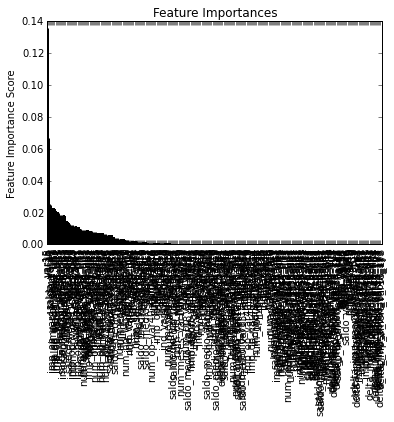

In [15]:
modelFit(gSearch5.best_estimator_, train, pred, 'TARGET')

In [17]:
submission = pd.DataFrame({'ID' : test.ID, 'TARGET' : gSearch5.best_estimator_.predict_proba(test[pred])[:,1]})
submission.to_csv('submission2.csv', index = False)

In [3]:
gbm1 = GradientBoostingClassifier(learning_rate = 0.05,\
                           n_estimators = 200,\
                           max_depth = 9,\
                           min_samples_split = 400,\
                           min_samples_leaf = 50,\
                           max_features = 'sqrt',\
                           subsample = 0.8,\
                           random_state = 10)
modelFit(gbm1, train, pred, 'TARGET')